In [1]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/fashion', one_hot=True)

Extracting input/fashion/train-images-idx3-ubyte.gz
Extracting input/fashion/train-labels-idx1-ubyte.gz
Extracting input/fashion/t10k-images-idx3-ubyte.gz
Extracting input/fashion/t10k-labels-idx1-ubyte.gz


In [2]:
# 1. Define Variables and Placeholders
X = tf.placeholder(tf.float32, [None, 28 * 28 * 1])
Y_ = tf.placeholder(tf.float32, [None, 10]) # correct answers(labels)

XX = tf.reshape(X, [-1, 28, 28, 1])

#define weight variable for a convolutional layer
W_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
#define convolutional layer in model
B_1 = tf.Variable(tf.constant(0.1, shape=[4]))
Y_1 = tf.nn.relu(tf.nn.conv2d(XX, W_1, strides=[1, 1, 1, 1], padding='SAME') + B_1)

W_2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B_2 = tf.Variable(tf.constant(0.1, shape=[8]))
Y_2 = tf.nn.relu(tf.nn.conv2d(Y_1, W_2, strides=[1, 2, 2, 1], padding='SAME') + B_2)

W_3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B_3 = tf.Variable(tf.constant(0.1, shape=[12]))
Y_3 = tf.nn.relu(tf.nn.conv2d(Y_2, W_3, strides=[1, 2, 2, 1], padding='SAME') + B_3)

#learning rate placeholder
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(0.50, global_step, 100, 0.96, staircase=True)
# placeholder for probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at 
# training time
pkeep = tf.placeholder(tf.float32, [])

Y_3Y = tf.reshape(Y_3, [-1, 7 * 7 * 12]) 

W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))
B_fc1 = tf.Variable(tf.constant(0.1, shape=[200]))
Y_fc1 = tf.nn.relu(tf.matmul(Y_3Y, W_fc1) + B_fc1)

#Y_fc1d = tf.nn.dropout(Y_fc1, pkeep)

W_fc2 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))

Ylogits = tf.matmul(Y_fc1, W_fc2) + B_fc2
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)

# 4. Define the accuracy 
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1)), tf.float32))

# 5. Define an optimizer
#train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy, global_step=global_step)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
#train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)
#train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy, global_step=global_step)

# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)


def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    # sess.run(train_step, feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 0.75})
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep: 1.0})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        #a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 1.0})
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep: 1.0})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        #a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0})
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)


# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
9999                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

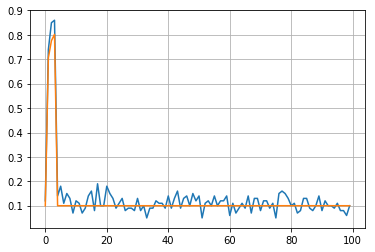

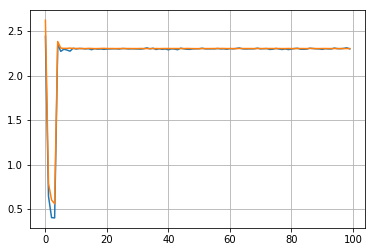

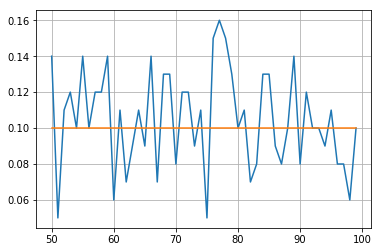

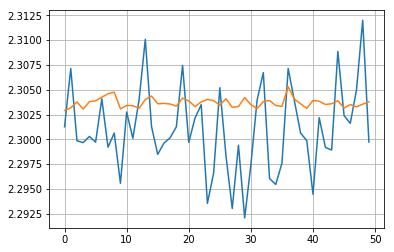

In [3]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()